In [1]:
from tqdm import tqdm
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

import warnings
warnings.simplefilter("ignore")
import matplotlib.ticker as ticker

helper classes and functions

In [2]:
def get_all_csv_file(root: str) -> list:
    """Extraction all unique ids from file names."""
    ids = []
    for dirname, _, filenames in os.walk(root):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".csv"):
                ids.append(path) 
    ids = list(set(filter(None, ids)))
    print(f"Extracted {len(ids)} csv files.")
    return ids

#csv_paths = get_all_csv_file("../input/brats20-dataset-training-validation/BraTS2020_TrainingData")

In [3]:
class GlobalConfig:
    root_dir = '../input/brats20-dataset-training-validation'
    train_root_dir = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    path_to_csv = './train_data.csv'
    pretrained_model_path = '../input/brats20203layercnn/last_epoch_model.pth'
    train_logs_path = '../input/brats20203layercnn/train_log.csv'
    seed = 55
    
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)

Data Preprocessing

In [4]:
survival_info_df = pd.read_csv('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
name_mapping_df = pd.read_csv('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True) 


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

paths = []
for _, row  in df.iterrows():
    
    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]
    
    if phase == 'Training':
        path = os.path.join(config.train_root_dir, id_)
    else:
        path = os.path.join(config.test_root_dir, id_)
    paths.append(path)
    
df['path'] = paths

#split data on train, test, split
#train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=69, shuffle=True)
#train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)
train_data["Age_rank"] =  train_data["Age"] // 10 * 10
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

skf = StratifiedKFold(
    n_splits=7, random_state=config.seed, shuffle=True
)
for i, (train_index, val_index) in enumerate(
        skf.split(train_data, train_data["Age_rank"])
        ):
        train_data.loc[val_index, "fold"] = i

train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)
train_data.to_csv("train_data.csv", index=False)

train_df -> (201, 12) val_df -> (34, 12) test_df -> (133, 10)


# Dataset DataLoader

In [5]:
class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test"):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.is_resize = is_resize
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)#.transpose(2, 0, 1)

            img = self.normalize(img)
            images.append(img)
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        
        if self.phase != "test":
            mask_path =  os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)
            mask = self.preprocess_mask_labels(mask)
    
            img=img.astype(np.float32)
            mask=mask.astype(np.float32)
            
        
            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }
        
        return {
            "Id": id_,
            "image": img,
        }
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def preprocess_mask_labels(self, mask: np.ndarray):

        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask

In [6]:
def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
    
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=False,   
    )
    return dataloader

In [7]:
dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase='valid', fold=0)
len(dataloader)

34

In [8]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape

(['BraTS20_Training_003'],
 torch.Size([1, 4, 155, 240, 240]),
 torch.Size([1, 3, 155, 240, 240]))

Num uniq Image values : 611
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([8898193,   29807]))


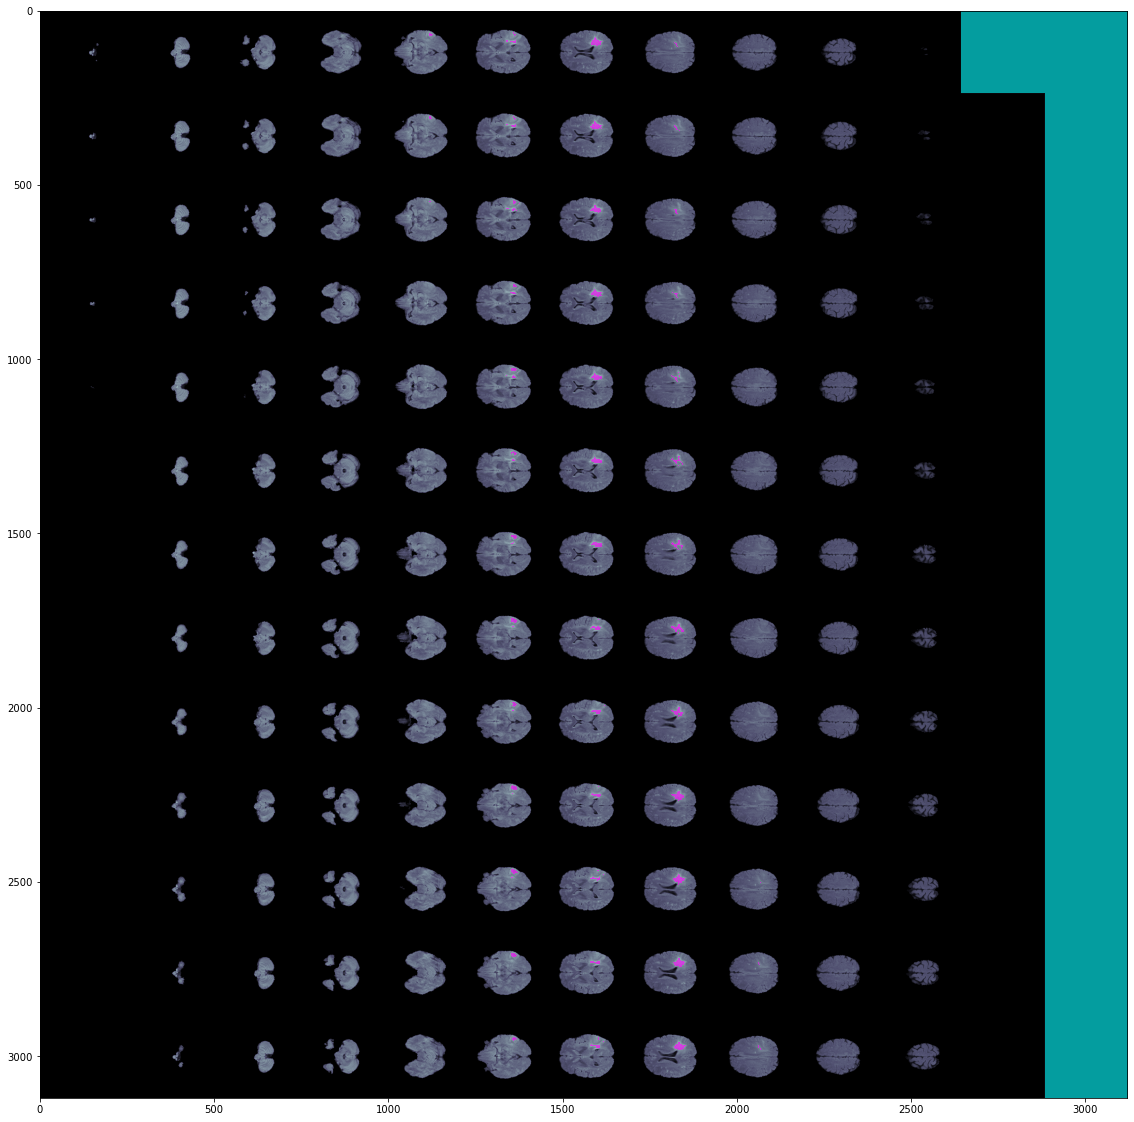

In [9]:
img_tensor = data['image'].squeeze()[0].cpu().detach().numpy() 
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

# Metric and Loss

In [10]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss
    
# helper functions for testing.  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

# 3DUnet

In [11]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        return self.conv(x1)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        #self.enc3 = Down(4 * n_channels, 8 * n_channels)
        #self.enc4 = Down(8 * n_channels, 8 * n_channels)

        #self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 4 * n_channels)
        self.dec3 = Up(4 * n_channels, 2 * n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        #x5 = self.enc4(x4)

        #mask = self.dec1(x5, x4)
        #mask = self.dec2(mask, x3)
        mask = self.dec2(x4, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask

# Trainer

In [12]:
class Trainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {
            phase: get_dataloader(
                dataset = dataset,
                path_to_csv = path_to_csv,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                num_workers = 4
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
         
    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, data_batch in enumerate(dataloader):
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss
        
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")

        self._save_train_history()
            
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
                
            plt.tight_layout()
            plt.show()
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i] 
                     for i in list(range(len(logs_))) 
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

training process

In [13]:
model = UNet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda')

In [14]:
trainer = Trainer(net=model,
                  dataset=BratsDataset,
                  criterion=BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=0,
                  num_epochs=20,
                  path_to_csv = config.path_to_csv,)

if True:
    trainer.load_predtrain_model(config.pretrained_model_path)
    
    # if need - load the logs.      
    train_logs = pd.read_csv(config.train_logs_path)
    trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
    trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
    trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
    trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
    trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
    trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

device: cuda
Predtrain model loaded


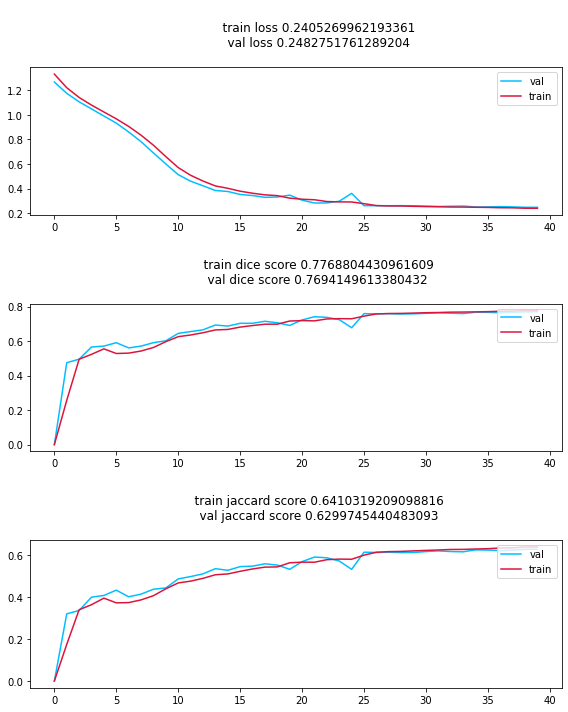

In [15]:
#%%time
#trainer.run()
trainer._plot_train_history()

# Experiments and Results

In [16]:
val_dataloader = get_dataloader(BratsDataset, 'train_data.csv', phase='valid', fold=0)
len(dataloader)

34

In [18]:
df = pd.read_csv('train_data.csv').iloc[142:147,:].reset_index(drop=True)
dataset = BratsDataset(df,  phase='valid')
dataloader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,   
    )

In [19]:
data = next(iter(dataloader))
while data['Id']!=['BraTS20_Training_164']:
    print(data['Id'])
    data = next(iter(dataloader))

In [20]:
feature=[]
module_name=[]

In [21]:
def hook(module,input,output):
    module_name.append(module.__class__)
    feature.append(output.clone().detach().cpu().numpy())
model.conv.register_forward_hook(hook)
model.enc1.register_forward_hook(hook) 
model.enc2.register_forward_hook(hook)
model.enc3.register_forward_hook(hook)
model.dec2.register_forward_hook(hook)
model.dec3.register_forward_hook(hook)
model.dec4.register_forward_hook(hook)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
with torch.no_grad():
    #data = next(iter(dataloader))
    imgs, targets = data['image'], data['mask']
    imgs, targets = imgs.to(device), targets.to(device)
    logits = model(imgs)
    logits = logits.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

In [25]:
logits.shape

(1, 3, 155, 240, 240)

In [26]:
def targetplot(i):
    plt.figure(figsize=(20, 10))
    plt.subplot(1,3,1)
    plt.imshow(targets[0,0,i,:,:],cmap='bone')
    plt.title('Whole Tumor(WT)')
    plt.subplot(1,3,2)
    plt.imshow(targets[0,1,i,:,:],cmap='bone')
    plt.title('Tumor Core(TC)')
    plt.subplot(1,3,3)
    plt.imshow(targets[0,2,i,:,:],cmap='bone')
    plt.title('Enhancing Tumor(ET)')

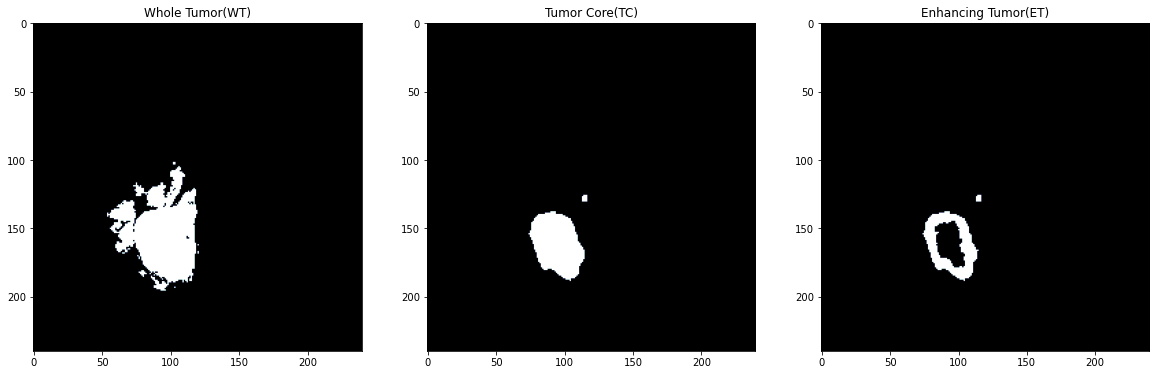

In [27]:
targetplot(90)

In [28]:
image=imgs.detach().cpu().numpy()
image.shape

(1, 4, 155, 240, 240)

In [29]:
def imageplot(i):
    plt.figure(figsize=(20, 10))
    plt.subplot(1,4,1)
    plt.imshow(image[0,0,i,:,:],cmap='bone')
    plt.title('t2-flair')
    plt.subplot(1,4,2)
    plt.imshow(image[0,1,i,:,:],cmap='bone')
    plt.title('t1')
    plt.subplot(1,4,3)
    plt.imshow(image[0,2,i,:,:],cmap='bone')
    plt.title('t1GD')
    plt.subplot(1,4,4)
    plt.imshow(image[0,3,i,:,:],cmap='bone')
    plt.title('t2')

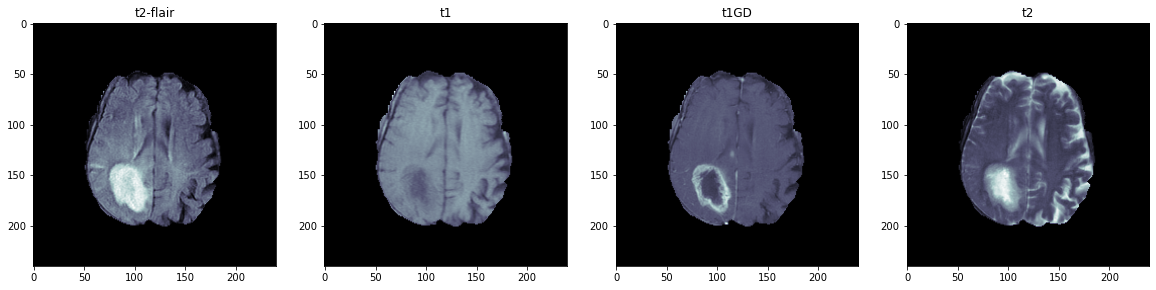

In [30]:
imageplot(90)

In [31]:
def feaplot(j,i):
    plt.figure(figsize=(20, 10))
    for k in range(24):
        plt.subplot(4,6,k+1)
        plt.imshow(feature[j][0,k,i,:,:],cmap='bone')

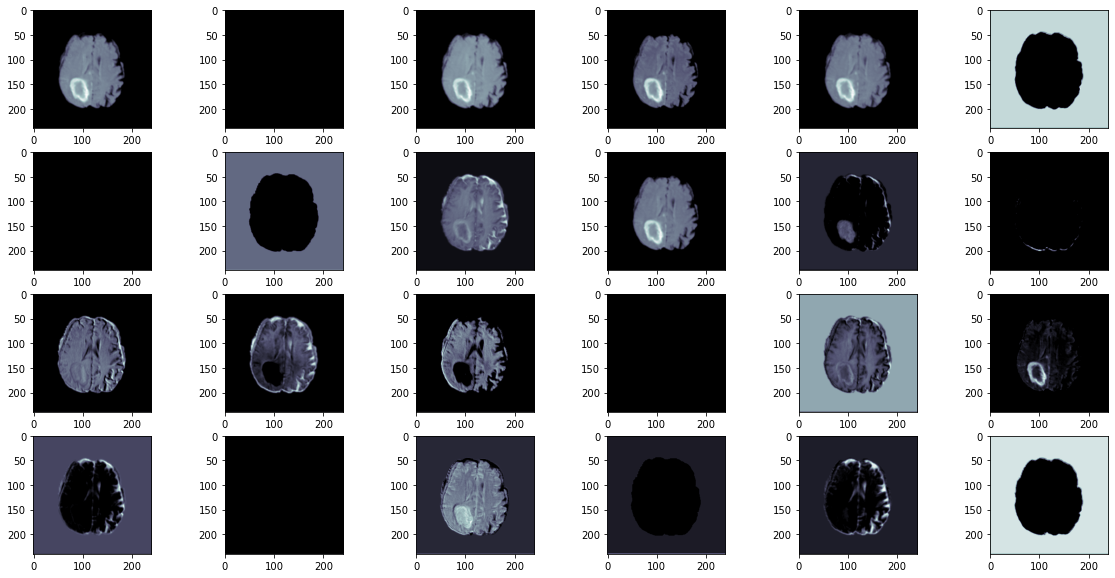

In [32]:
feaplot(0,90)

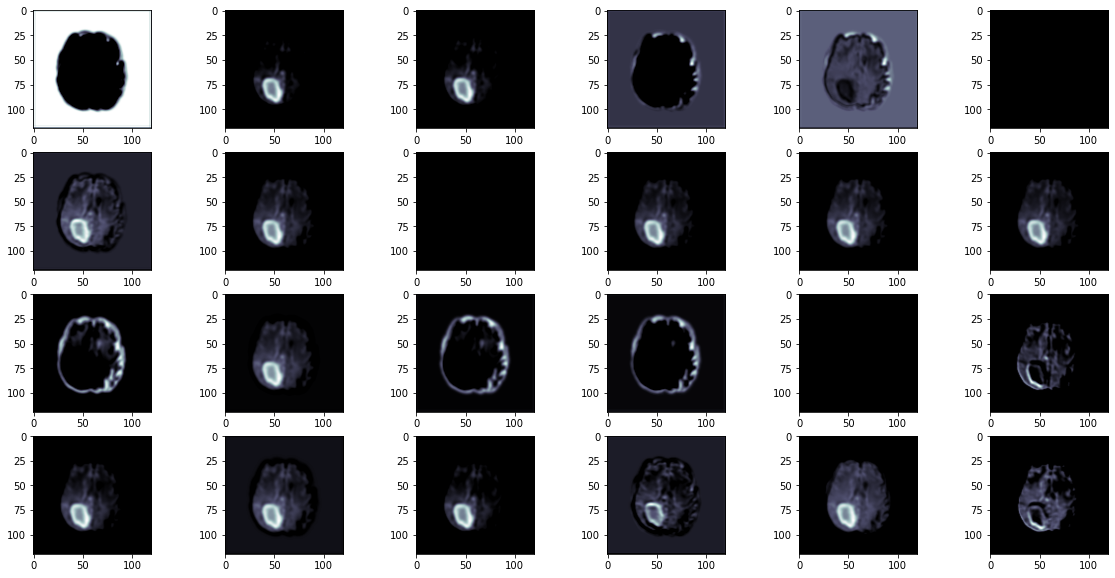

In [33]:
feaplot(1,45)

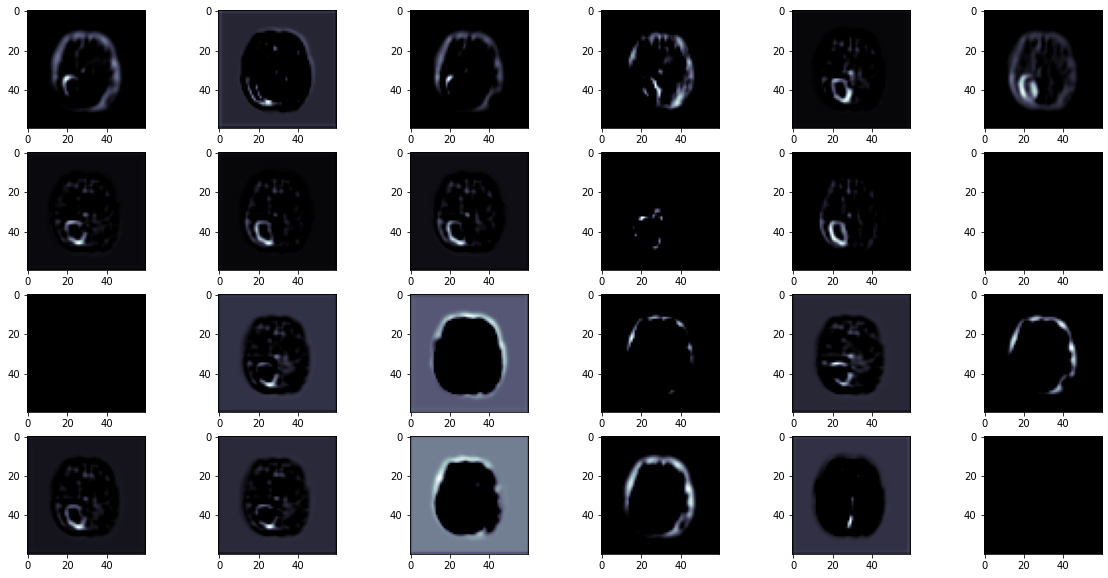

In [34]:
feaplot(2,22)

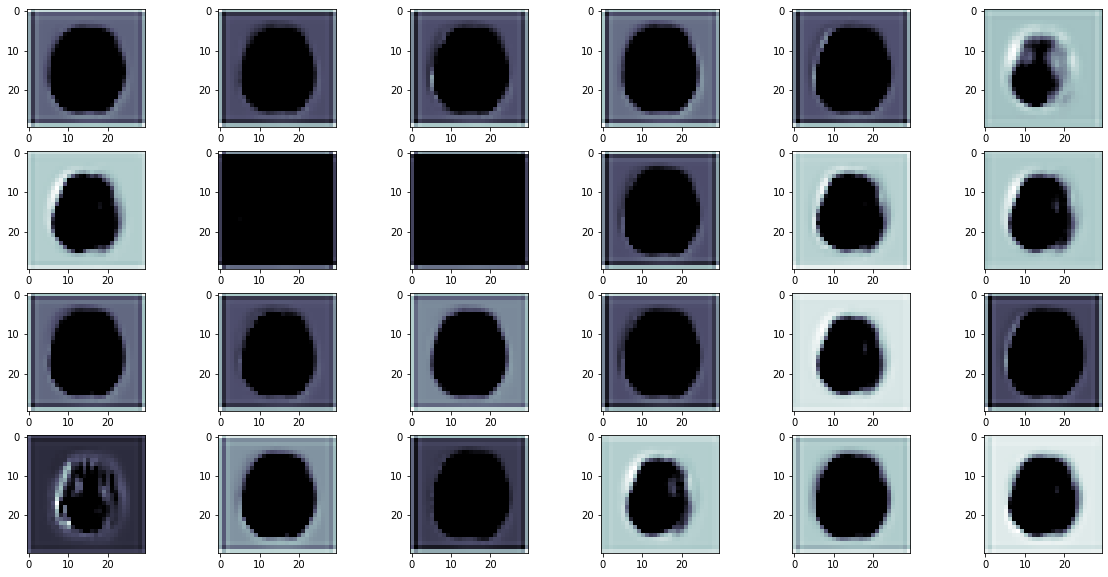

In [35]:
feaplot(3,11)

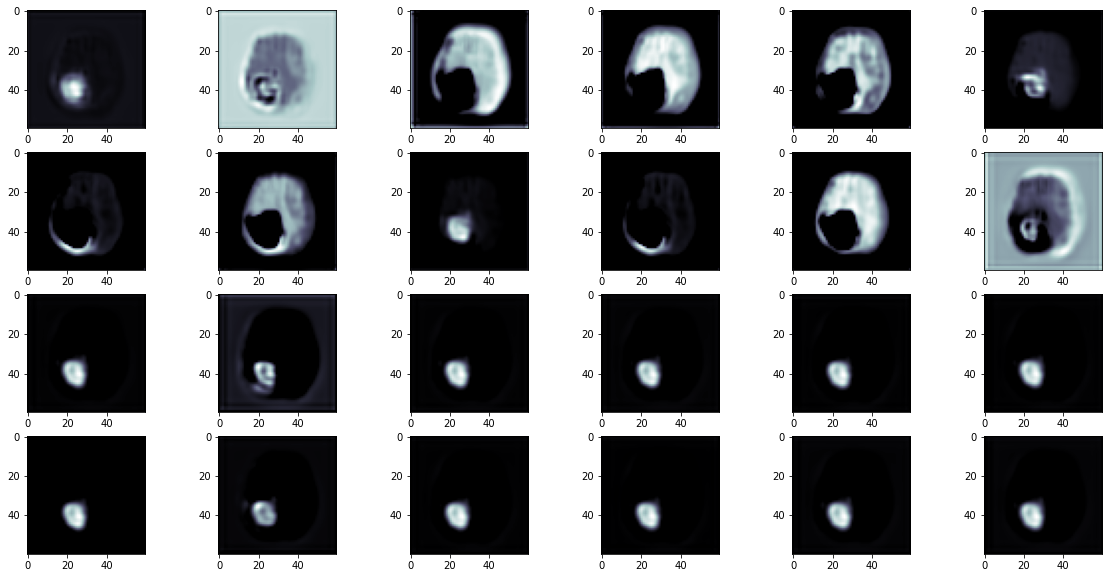

In [36]:
feaplot(4,22)

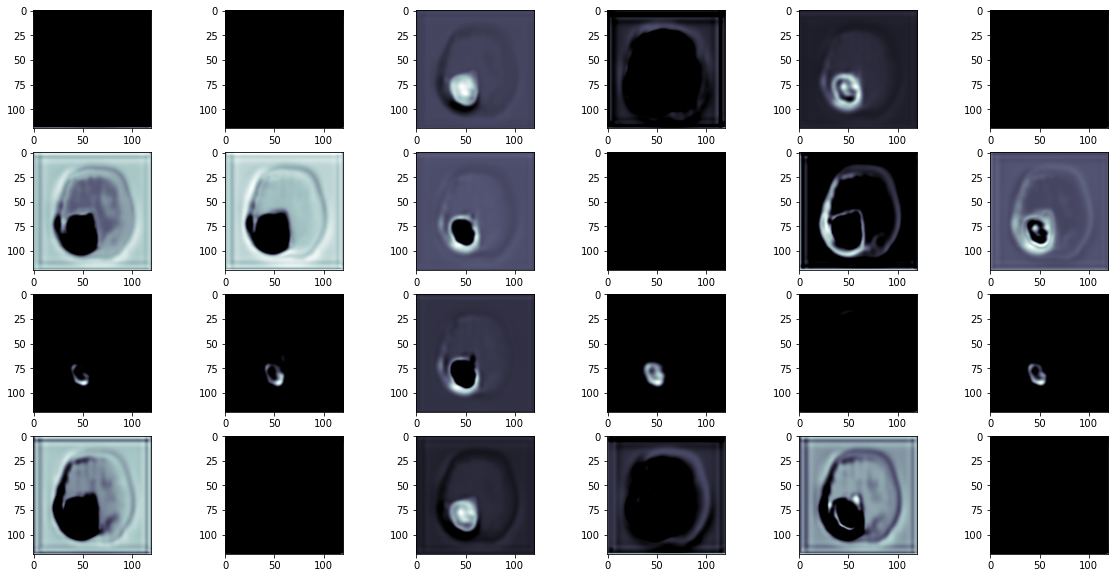

In [37]:
feaplot(5,45)

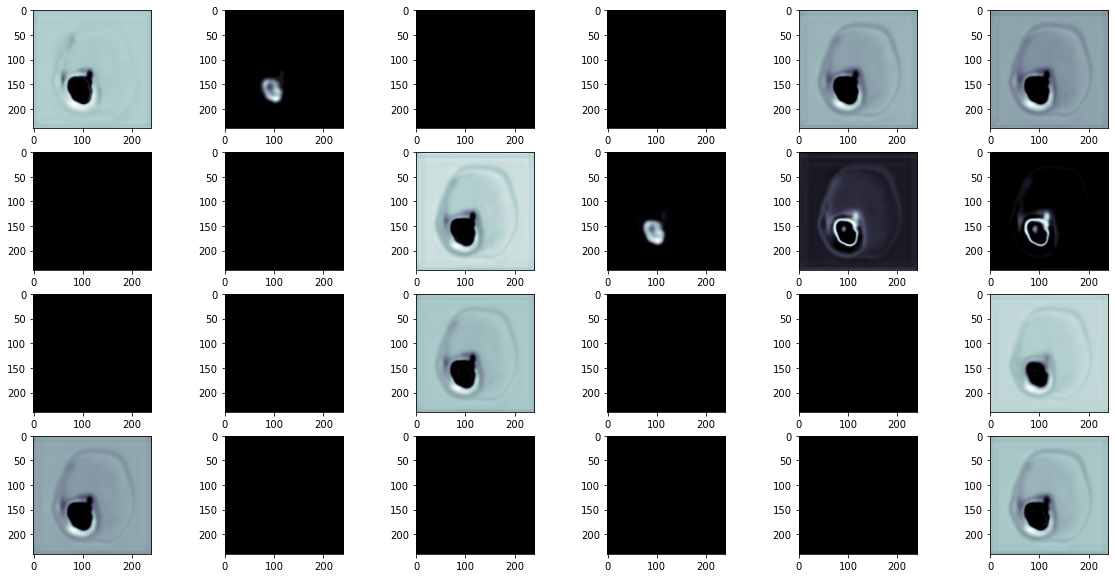

In [38]:
feaplot(6,90)

In [39]:
def logitsplot(i):
    plt.figure(figsize=(20, 10))
    plt.subplot(1,4,1)
    plt.imshow(logits[0,0,i,:,:],cmap='bone')
    plt.title('Whole Tumor(WT)')
    plt.subplot(1,4,2)
    plt.imshow(logits[0,1,i,:,:],cmap='bone')
    plt.title('Tumor Core(TC)')
    plt.subplot(1,4,3)
    plt.imshow(logits[0,2,i,:,:],cmap='bone')
    plt.title('Enhancing Tumor(ET)')

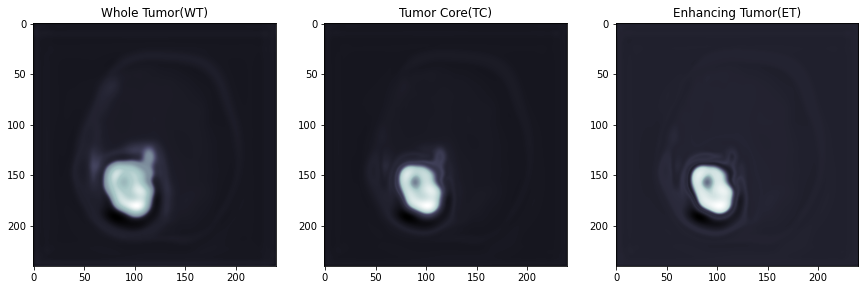

In [40]:
logitsplot(90)

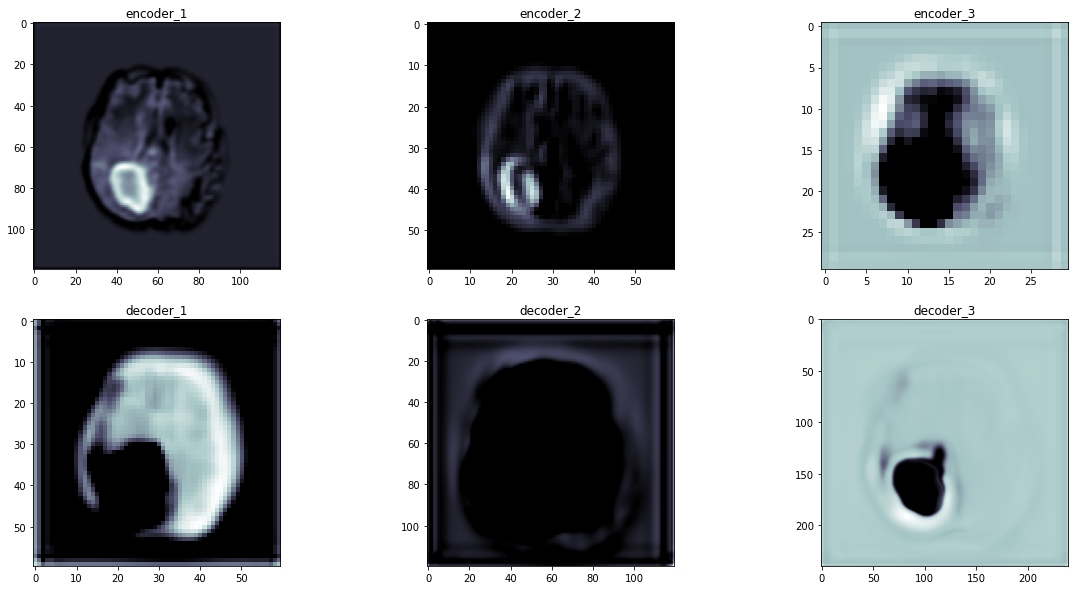

In [41]:
plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.imshow(feature[1][0,6,45,:,:],cmap='bone')
plt.title('encoder_1')
plt.subplot(2,3,2)
plt.imshow(feature[2][0,5,22,:,:],cmap='bone')
plt.title('encoder_2')
plt.subplot(2,3,3)
plt.imshow(feature[3][0,5,11,:,:],cmap='bone')
plt.title('encoder_3')
plt.subplot(2,3,4)
plt.imshow(feature[4][0,2,22,:,:],cmap='bone')
plt.title('decoder_1')
plt.subplot(2,3,5)
plt.imshow(feature[5][0,3,45,:,:],cmap='bone')
plt.title('decoder_2')
plt.subplot(2,3,6)
plt.imshow(feature[6][0,0,90,:,:],cmap='bone')
plt.title('decoder_3')
plt.savefig('cnnfeature3')